In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.compose import ColumnTransformer

In [10]:
# Loading data
df = pd.read_csv("dataset.csv")
df.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nationality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,8,2,15,1,1,1,23,27,6,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,12,1,3,0,1,1,22,28,10,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [11]:
numerical_features = [
    "Application order","Age at enrollment", "Curricular units 1st sem (credited)", "Curricular units 1st sem (enrolled)",
    "Curricular units 1st sem (evaluations)","Curricular units 1st sem (approved)","Curricular units 1st sem (grade)",
    "Curricular units 1st sem (without evaluations)","Curricular units 2nd sem (credited)","Curricular units 2nd sem (enrolled)",
    "Curricular units 2nd sem (evaluations)","Curricular units 2nd sem (approved)",
    "Curricular units 2nd sem (without evaluations)","Unemployment rate","Inflation rate","GDP","Curricular units 2nd sem (grade)"
]
categorical_features = [
    "Marital status","Application mode","Course","Daytime/evening attendance","Previous qualification","Nationality",
    "Mother's qualification","Father's qualification","Mother's occupation","Father's occupation","Displaced",
    "Educational special needs","Debtor","Tuition fees up to date","Gender","Scholarship holder","International"
]

target = "Target"


I. Math introduction

Because in our logistic regression we have 3 classes we have to implement one vs many solution, so our $W$ weight matrix has three rows where each row will have a weights where each row corresponds to one class and learns how to distinguish that class from all others.


First we have to do linear combination of input variables with their weights
$$ scores = X * W^T + b^T$$

But scores is a matrix with values from $-\inf$ to  $+\inf$ so we have to changes this to range from 0 to 1 because in logistic regression we are predicting a probability. This is called softmax function

$$ \hat{p_k} = \frac{\exp{(scores_k)}}{\sum_{j=1}^{K}\exp{(scores)}}$$


Because we are using gradient descent to get our model better, we will be minimalizing cost function. In our classification problem we are going to use Cross-Entropy cost function

$$J(W,b)  = -\frac{1}{m}\sum_{k=1}^{K}(y_k*\log(p_k))$$

After one iteration we have to update our $W$ and $b$:


$$ \nabla_w{J(W,b)} = \frac{1}{m}\sum_{k=1}^{n}x(\hat{p_k} - y_k)$$

$$ \nabla_b{J(W,b)} = \frac{1}{m}\sum_{k=1}^{n}(\hat{p_k} - y_k)$$

So after one iteration we can update $W$ and $b$:

$$W_x = W - lr * dW$$

$$b_x = b - lr * db$$


We can repeat this process until current_iter < max_iteration

After iterations,  we have to part our set to $n$ batches. Batches are a subsets of current training set, and after one iteration te set on which our model making calculations is changing:
$$
X_{\text{new}} = \text{Batches}[\text{prev} + n_{\text{batches}}]
$$


$$ prev = prev + n_{batches} $$

In [12]:

class LogisticRegression:
    def __init__(self, lr=0.001, n_iters=10000, batch_size=64):
        self.lr = lr
        self.batch_idx = 0
        self.n_iters = n_iters
        self.batch_size = batch_size
        self.weights = None
        self.bias = None
        self.errors = []
        self.n_classes = None

    def error_function(self, y, predicted, m_samples):
        return -np.sum(y * np.log(predicted + 1e-15)) / m_samples

    def fit(self, X, y):
        m_samples, n_features = X.shape
        self.n_classes = y.shape[1]
        self.weights = np.zeros((n_features, self.n_classes))
        self.bias = np.zeros((1, self.n_classes))

        for i in range(self.n_iters):
            indices = np.random.permutation(m_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            for start_idx in range(0, m_samples, self.batch_size):
                end_idx = start_idx + self.batch_size
                X_batch = X_shuffled[start_idx:end_idx]
                y_batch = y_shuffled[start_idx:end_idx]

                predict = self.predict(X_batch)
                dw = (1 / X_batch.shape[0]) * np.dot(X_batch.T, (predict - y_batch))
                db = (1 / X_batch.shape[0]) * np.sum(predict - y_batch, axis=0, keepdims=True)

                self.weights -= self.lr * dw
                self.bias -= self.lr * db

            full_predict = self.predict(X)
            loss = self.error_function(y, full_predict, m_samples)
            self.errors.append(loss)

            if i % 100 == 0:
                print(f"Iteration {i}, Loss: {loss:.4f}")


    def softmax(self,z):
        return np.exp(z)/np.sum(np.exp(z),axis=1,keepdims=True)

    def predict(self, X):
        z = np.dot(X, self.weights) + self.bias
        return self.softmax(z)

    def predict_class(self, X_test):
        probabilities = self.predict(X_test)
        return np.argmax(probabilities, axis=1).reshape(-1, 1)

    def score(self, predicted, y,to_show):
        y_true = np.argmax(y, axis=1)
        correct = (predicted.flatten() == y_true)
        accuracy = np.mean(correct)
        print("Correct predictions:", correct)
        print("Accuracy:", accuracy)
        if to_show:
            plt.plot(np.arange(len(self.errors)), self.errors)
            plt.show()


In [13]:
# HERE Y has to be in onehotencoder [0 0 ...  1]
X = df.drop(["Target"], axis=1)
y = df["Target"]

# Dropout -  0
# Graduate - 1
# Enrolled - 2

X_train,X_temp,y_train,y_temp = train_test_split(X,y,train_size=0.4,random_state=42)
X_val,X_test,y_val,y_test = train_test_split(X_temp,y_temp,random_state=42,train_size=0.5)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore',sparse_output=False), categorical_features)
    ]
)

X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

y_train_processed = pd.get_dummies(y_train,columns=["Target"]).astype(int).to_numpy()
y_test_processed = pd.get_dummies(y_test,columns=["Target"]).astype(int).to_numpy()
y_val_processed = pd.get_dummies(y_val,columns=["Target"]).astype(int).to_numpy()


#main part
clf = LogisticRegression()
clf.fit(X_train_processed,y_train_processed)


Iteration 0, Loss: 1.0650
Iteration 100, Loss: 0.6819
Iteration 200, Loss: 0.6317
Iteration 300, Loss: 0.6064
Iteration 400, Loss: 0.5901
Iteration 500, Loss: 0.5784
Iteration 600, Loss: 0.5693
Iteration 700, Loss: 0.5620
Iteration 800, Loss: 0.5559
Iteration 900, Loss: 0.5506
Iteration 1000, Loss: 0.5460
Iteration 1100, Loss: 0.5419
Iteration 1200, Loss: 0.5383
Iteration 1300, Loss: 0.5350
Iteration 1400, Loss: 0.5320
Iteration 1500, Loss: 0.5293
Iteration 1600, Loss: 0.5268
Iteration 1700, Loss: 0.5245
Iteration 1800, Loss: 0.5223
Iteration 1900, Loss: 0.5203
Iteration 2000, Loss: 0.5184
Iteration 2100, Loss: 0.5167
Iteration 2200, Loss: 0.5150
Iteration 2300, Loss: 0.5135
Iteration 2400, Loss: 0.5120
Iteration 2500, Loss: 0.5106
Iteration 2600, Loss: 0.5093
Iteration 2700, Loss: 0.5080
Iteration 2800, Loss: 0.5068
Iteration 2900, Loss: 0.5056
Iteration 3000, Loss: 0.5046
Iteration 3100, Loss: 0.5035
Iteration 3200, Loss: 0.5025
Iteration 3300, Loss: 0.5015
Iteration 3400, Loss: 0.50

Correct predictions: [ True  True  True ... False  True  True]
Accuracy: 0.7733433734939759


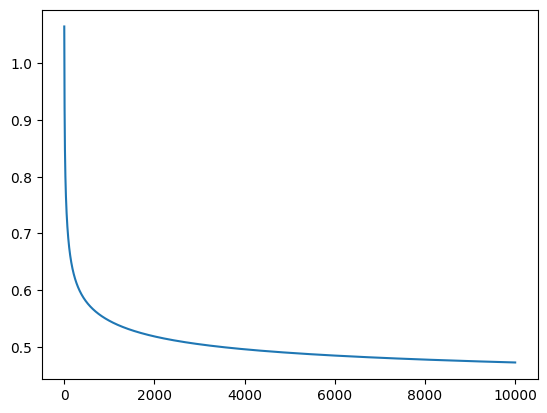

Correct predictions: [False False  True ...  True  True False]
Accuracy: 0.7565938206480783
Correct predictions: [ True  True  True ...  True  True  True]
Accuracy: 0.819672131147541


In [14]:
#TEST set
predicted = clf.predict_class(X_test_processed)
clf.score(predicted,y_test_processed,True)

#VALIDATION set
predicted = clf.predict_class(X_val_processed)
clf.score(predicted,y_val_processed,False)

#TRAIN set
predicted = clf.predict_class(X_train_processed)
clf.score(predicted,y_train_processed,False)

In [15]:
lm = linear_model.LogisticRegression(multi_class='multinomial',max_iter=10000)
lm.fit(X_train_processed, y_train)
s1 = lm.score(X_test_processed, y_test)
s2 = lm.score(X_val_processed, y_val)
s3 = lm.score(X_train_processed, y_train)

s1, s2, s3

C:\Users\Aleksander\anaconda3\envs\msid_lista_1\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


(0.7695783132530121, 0.7596081386586285, 0.8224985867721877)